Connected to Python 3.10.11

### Load libraries

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd

# Directly import helper function
notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

from utils import add_src_to_path
add_src_to_path()

from data_split import split_time_series_by_river
from rf_model import train_and_apply_rf_with_tuning
from plot_predictions import plot_predictions_by_river
from plot_predictions import plot_actual_vs_predicted

### Select River system and load dataset

In [2]:
# Choose from "Bristol Bay", "Fraser River" and "Columbia River"
river_system = "Fraser River"

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))  # assumes notebook is in /notebooks
data_path = os.path.join(project_root, 'data', 'Combined_FeatureSet_For_Model.csv')

combined_df = pd.read_csv(data_path)
# Optional: Select river system
combined_df = combined_df[combined_df["System"] == river_system]
# Optional: Select river
#combined_df = combined_df[combined_df["River"] == "Alagnak"]

In [3]:
combined_df.columns

Index(['System', 'River', 'Year', 'Total_Returns', 'AgeClass_0.1',
       'AgeClass_0.2', 'AgeClass_0.3', 'AgeClass_0.4', 'AgeClass_0.5',
       'AgeClass_1.1', 'AgeClass_1.2', 'AgeClass_1.3', 'AgeClass_1.4',
       'AgeClass_1.5', 'AgeClass_2.1', 'AgeClass_2.2', 'AgeClass_2.3',
       'AgeClass_2.4', 'AgeClass_3.1', 'AgeClass_3.2', 'AgeClass_3.3',
       'AgeClass_3.4', 'Total_Returns_NextYear', 'Pacea_ALPI_Anomaly',
       'npi_mean_NovMar', 'oni_mean_DecFeb', 'mei_mean_AprSep',
       'npgo_mean_DecFeb', 'ao_mean_DecMar', 'pdo_mean_DecMar',
       'pdo_mean_MaySep', 'sst_aprjul', 'sst_anom', 'sss_mayaug',
       'total_spawners_y_minus_2', 'total_spawners_y_minus_3',
       'total_spawners_y_minus_4', 'total_spawners_y_minus_2_to_4',
       'mean_temp_JunAug', 'mean_temp_MaySep', 'max_temp_JunAug',
       'mean_discharge_MarMay', 'max_discharge_AprSep'],
      dtype='object')

### Optional: Add additional time lagged features

In [4]:
if True:
    features_to_lag = ['Total_Returns', 'AgeClass_0.1',
       'AgeClass_0.2', 'AgeClass_0.3', 'AgeClass_0.4', 'AgeClass_0.5',
       'AgeClass_1.1', 'AgeClass_1.2', 'AgeClass_1.3', 'AgeClass_1.4',
       'AgeClass_1.5', 'AgeClass_2.1', 'AgeClass_2.2', 'AgeClass_2.3',
       'AgeClass_2.4', 'AgeClass_3.1', 'AgeClass_3.2', 'AgeClass_3.3',
       'AgeClass_3.4', 'Total_Returns_NextYear', 'Pacea_ALPI_Anomaly',
       'npi_mean_NovMar', 'oni_mean_DecFeb', 'npgo_mean_DecFeb',
       'ao_mean_DecMar', 'pdo_mean_DecMar', 'pdo_mean_MaySep']
    for feat in features_to_lag:
        for lag in [1, 2, 3, 4, 5]:
            combined_df[f'{feat}_Yminus{lag}'] = combined_df.groupby(['System', 'River'])[feat].shift(lag)

C:\Users\julia\AppData\Local\Temp\ipykernel_1664\2577719197.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df[f'{feat}_Yminus{lag}'] = combined_df.groupby(['System', 'River'])[feat].shift(lag)
C:\Users\julia\AppData\Local\Temp\ipykernel_1664\2577719197.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df[f'{feat}_Yminus{lag}'] = combined_df.groupby(['System', 'River'])[feat].shift(lag)
C:\Users\julia\AppData\Local\Temp\ipykernel_1664\2577719197.py:12: PerformanceWarning: DataFrame is highly fragmented.

In [5]:
combined_df.columns

Index(['System', 'River', 'Year', 'Total_Returns', 'AgeClass_0.1',
       'AgeClass_0.2', 'AgeClass_0.3', 'AgeClass_0.4', 'AgeClass_0.5',
       'AgeClass_1.1',
       ...
       'pdo_mean_DecMar_Yminus1', 'pdo_mean_DecMar_Yminus2',
       'pdo_mean_DecMar_Yminus3', 'pdo_mean_DecMar_Yminus4',
       'pdo_mean_DecMar_Yminus5', 'pdo_mean_MaySep_Yminus1',
       'pdo_mean_MaySep_Yminus2', 'pdo_mean_MaySep_Yminus3',
       'pdo_mean_MaySep_Yminus4', 'pdo_mean_MaySep_Yminus5'],
      dtype='object', length=178)

In [6]:
# Optional: Standardize Total_Returns_NextYear
if (False):
    # Step 1: Compute per-river return stats
    return_stats = combined_df.groupby('River')['Total_Returns_NextYear'].agg(
        returns_mean='mean',
        returns_std='std'
    ).reset_index()

    # Step 2: Merge stats temporarily for scaling
    combined_df = combined_df.merge(return_stats, on='River', how='left')

    # Step 3: Standardize Total_Returns_NextYear
    combined_df['Total_Returns_NextYear'] = (
        (combined_df['Total_Returns_NextYear'] - combined_df['returns_mean']) /
        combined_df['returns_std']
    )

    # Step 4: Drop the extra columns again
    combined_df = combined_df.drop(columns=['returns_mean', 'returns_std'])

### Check for missing data and remove columns with missing data

In [7]:
# Optional: Keep Spawner data and remove river Ugashik and first four year (1963-1966) 
# as no data available 
if False:
    combined_df = combined_df.dropna(subset=['total_spawners_y_minus_2_to_4'])
    combined_df = combined_df.dropna(subset=['AgeClass_0.2_Yminus5'])

In [8]:
missing_summary = combined_df.isnull().sum()
missing_cols = missing_summary[missing_summary > 0]
print("Columns with missing values:\n")
print(missing_cols)

combined_df = combined_df.drop(columns=missing_cols.index)

Columns with missing values:

mei_mean_AprSep             140
sst_aprjul                  165
sst_anom                    165
total_spawners_y_minus_2      5
total_spawners_y_minus_4      5
                           ... 
pdo_mean_MaySep_Yminus1       5
pdo_mean_MaySep_Yminus2      10
pdo_mean_MaySep_Yminus3      15
pdo_mean_MaySep_Yminus4      20
pdo_mean_MaySep_Yminus5      25
Length: 146, dtype: int64


In [9]:
# Only years after 2000
#combined_df = combined_df[combined_df["Year"]>= 1995]

### Split data

In [10]:
train_df, test_df = split_time_series_by_river(
    combined_df,
    time_column="Year",
    group_columns=["System", "River"],
    test_fraction=0.2,
    gap_years=0  # Set to 1 if you want a 1-year gap between train and test
)

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (290, 32)
Test shape: (75, 32)


### One-hot encode the 'River' column

In [11]:
train_df["River_Name"] = train_df["River"] # For visualization
test_df["River_Name"] = test_df["River"]

train_df_encoded = pd.get_dummies(train_df, columns=["River"], prefix="River")
test_df_encoded = pd.get_dummies(test_df, columns=["River"], prefix="River")

### Train random forest with gridsearch hyperparameter tuning

In [12]:
results = train_and_apply_rf_with_tuning("GBRT", train_df_encoded, test_df_encoded, topk_feat = 10)

Selected features:
Index(['Total_Returns', 'AgeClass_0.2', 'AgeClass_1.1', 'AgeClass_1.2',
       'AgeClass_2.3', 'pdo_mean_MaySep', 'total_spawners_y_minus_3',
       'River_Chilko', 'River_Quesnel', 'River_Raft'],
      dtype='object')
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 200, 'min_samples_leaf': 2}
Random Forest R2: 0.49
Random Forest MSE: 313353785012.94
Random Forest MAPE: 268.24


### Optional: Fit ARIMA model on residuals (only works if only one river selected so far)

In [13]:
if True:    
    residuals = results["Timeline_train"]["Actual"] - results["Timeline_train"]["Predicted"]

    from statsmodels.tsa.arima.model import ARIMA
    residuals_series = pd.Series(residuals.values, index=results["Timeline_train"]["Year"])
    arima_model = ARIMA(residuals_series, order=(1,0,0))  # You may want to auto-tune this
    arima_fit = arima_model.fit()
    residual_forecast = arima_fit.forecast(steps=len(results["Timeline_test"]["Predicted"]))

    hybrid_pred = results["Timeline_test"]["Predicted"] + residual_forecast.values
    from sklearn.metrics import mean_squared_error, r2_score
    r2 = r2_score(results["Timeline_test"]["Actual"], hybrid_pred)
    print(r2)

    results["Timeline_test"]["Predicted"] = hybrid_pred

0.4911169750776775


C:\Users\julia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\julia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\julia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, 

### Performance metrics

In [14]:
results["Metrics_by_System"]

,System,R2,MSE,MAPE
0,Fraser River,0.491341,3.133538e+11,268.236949


In [15]:
results["Metrics_by_River"]

,River_Name,R2,MSE,MAPE
0,Chilko,0.017801,1.332137e+12,126.925134
1,Late Stuart,-2.713359,6.851605e+10,237.668779
2,Quesnel,0.856728,9.310644e+10,516.057606
3,Raft,-5.742205,1.041514e+09,300.092015
4,Stellako,0.444303,7.196792e+10,160.441212


### Plot predictions

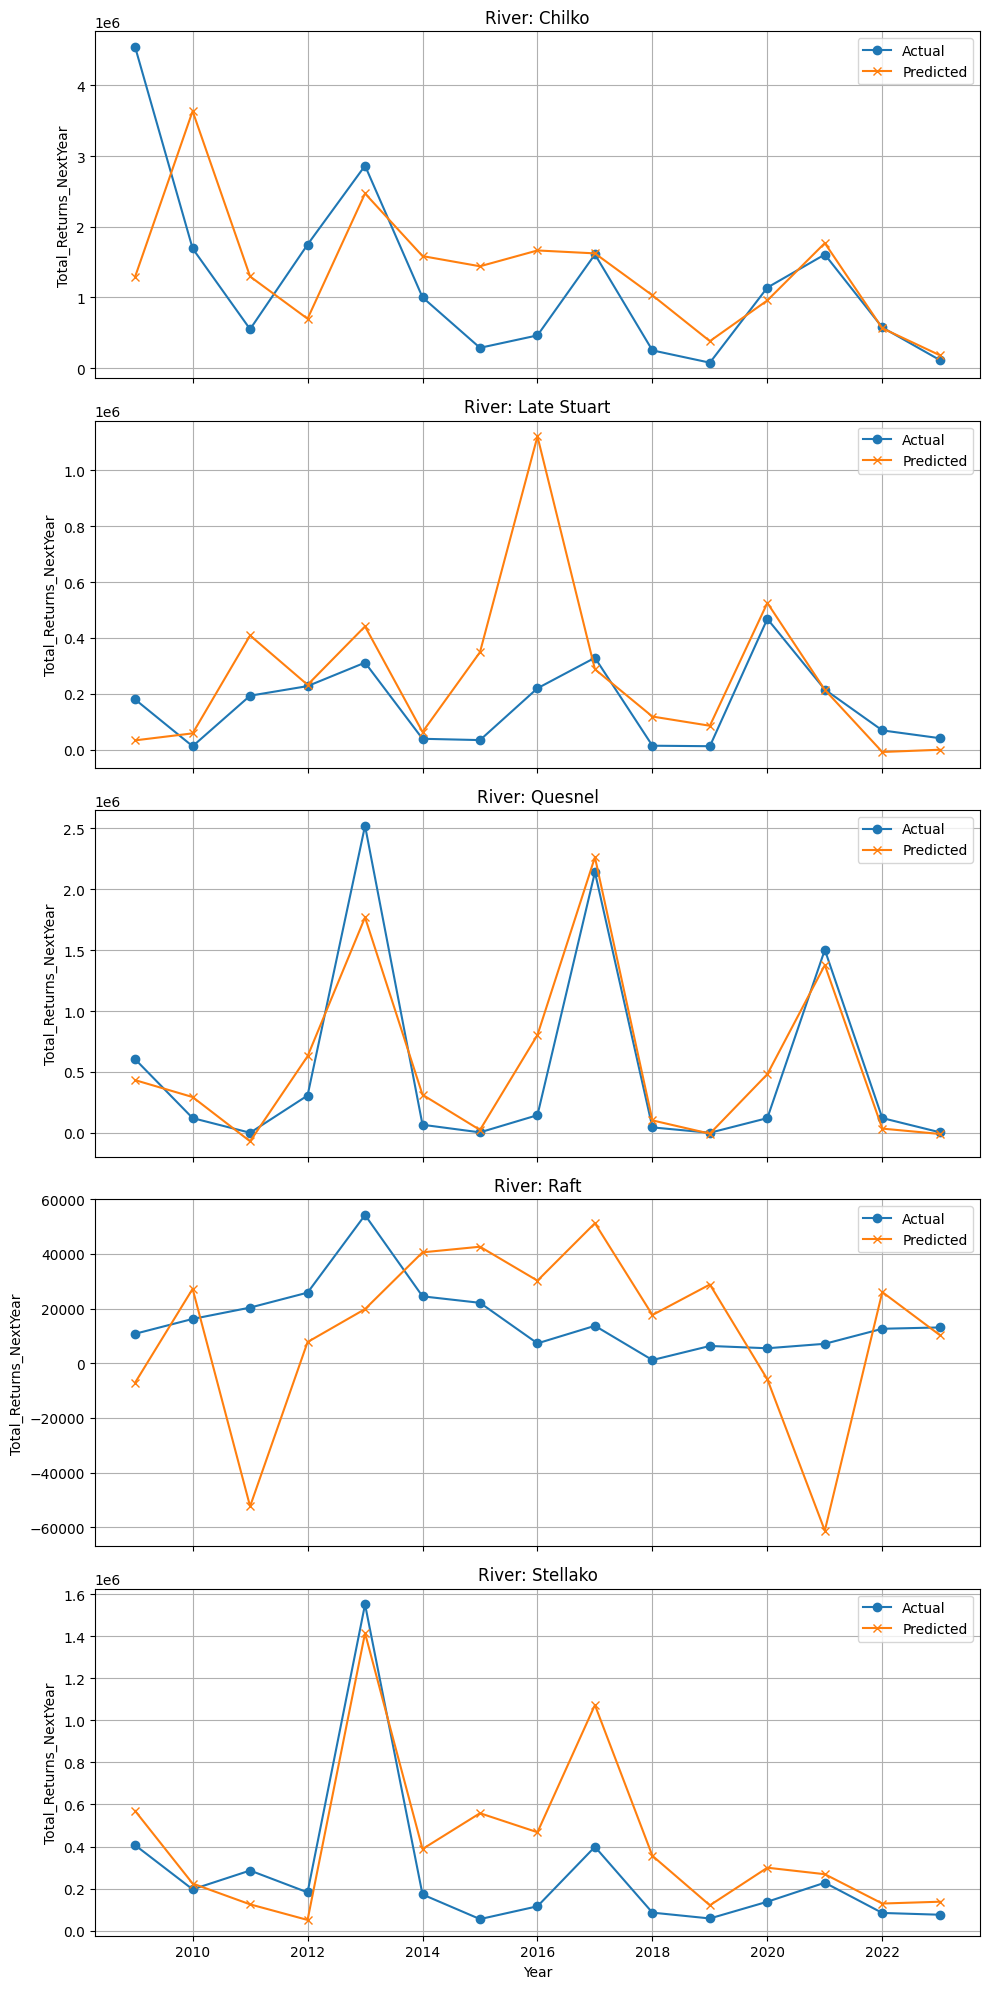

In [16]:
plot_predictions_by_river(results["Timeline_test"])

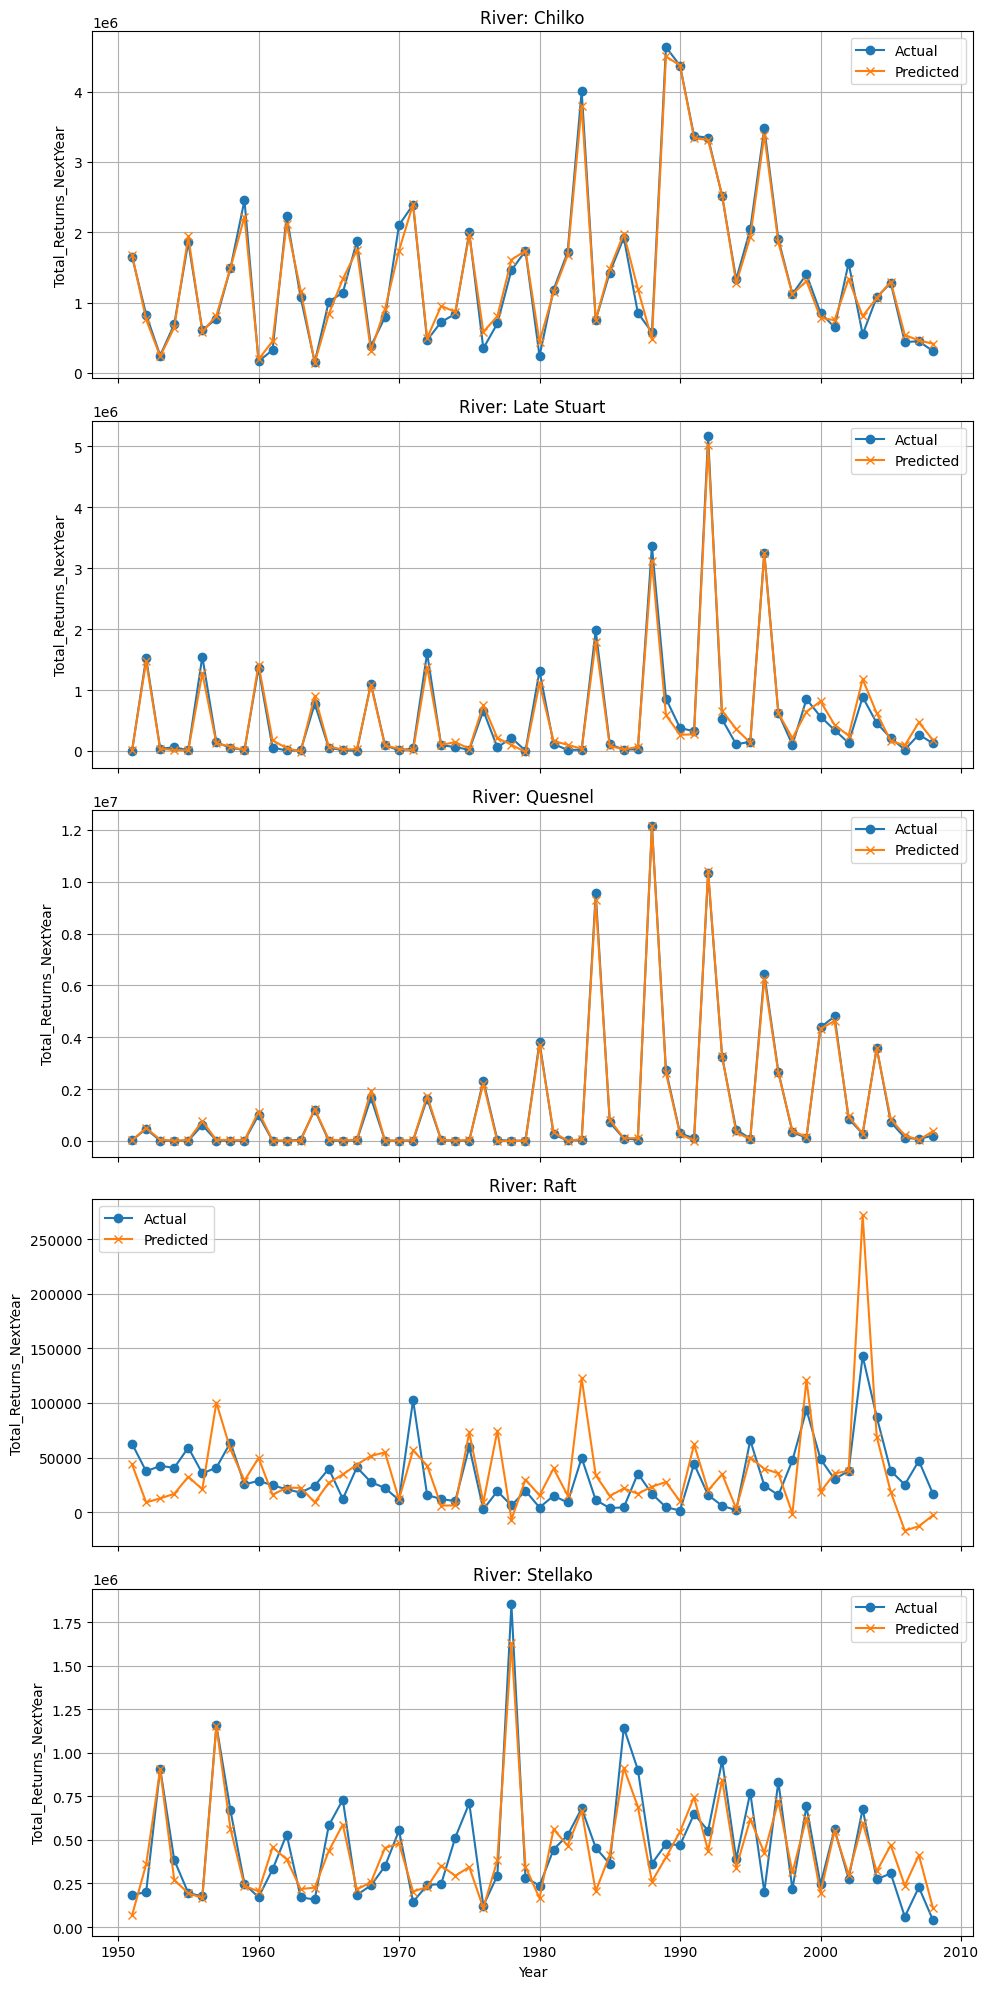

In [17]:
plot_predictions_by_river(results["Timeline_train"])

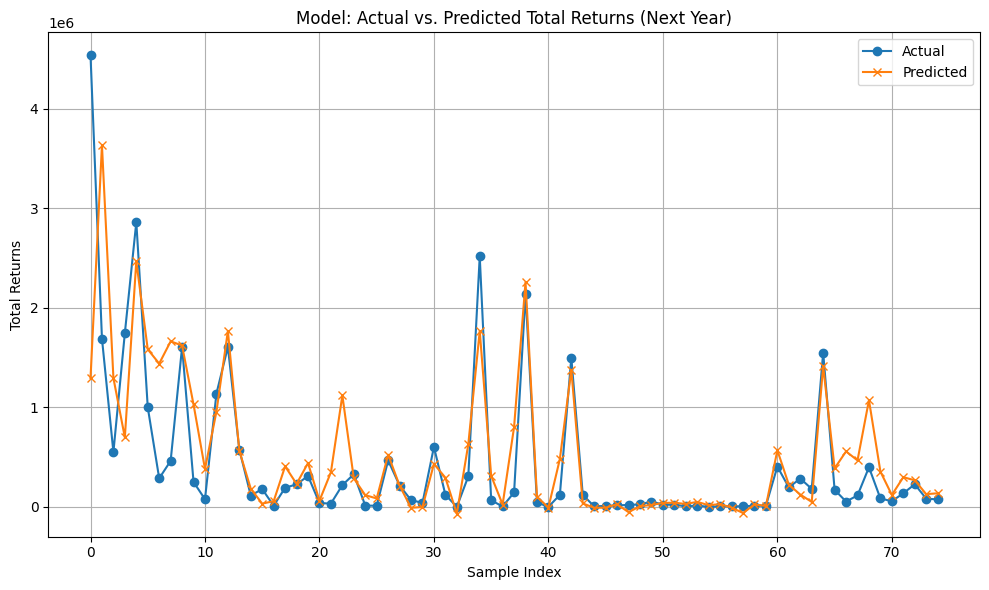

In [18]:
# Plot Predicted vs Actual
plot_actual_vs_predicted(results)

### Feature Importances

In [19]:
sorted_items = sorted(results["Feature_Importances"].items(), key=lambda x: x[1], reverse=True)
features, importances = zip(*sorted_items)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Most important on top
plt.tight_layout()
plt.show()

KeyError: 'Feature_Importances'